In [1]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [2]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [3]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus Class"].to_list())

In [4]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [5]:
# Import the preprocessing module
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [6]:
# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# Bottleneck size
n_bottleneck = 2

def create_model():
    
    # Input layer
    input_layer = keras.Input(shape=(n_inputs, 1))
    
    # --------------------
    # Encoder (Trial 14 params)
    # --------------------
    hidden_layer = keras.layers.Conv1D(
        filters=32,              # 1_filter
        kernel_size=6,           # 1_kernal
        activation="relu",
        padding="same"
    )(input_layer)

    hidden_layer = keras.layers.Conv1D(
        filters=128,             # 2_filter
        kernel_size=4,           # 2_kernal
        activation="relu",
        padding="same"
    )(hidden_layer)
    
    # Bottleneck
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck, name="bottleneck")(bottleneck_lay)

    # --------------------
    # Decoder (mirror)
    # --------------------
    reset_lay = keras.layers.Dense(49 * 128)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 128))(reset_lay)

    hidden_layer = keras.layers.Conv1DTranspose(
        filters=128,
        kernel_size=4,
        activation="relu",
        padding="same"
    )(reshape_lay)

    hidden_layer = keras.layers.Conv1DTranspose(
        filters=32,
        kernel_size=6,
        activation="relu",
        padding="same"
    )(hidden_layer)

    # Output layer
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Models
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)

    return model, encoder_model


# Build models
model, encoder_model = create_model()

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="mse"
)

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 49, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 49, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │        12,546 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6272)           │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 49, 128)        │        65,664 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 49, 32)         │        24,608 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 49, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,403 (540.64 KB)

 Trainable params: 138,403 (540.64 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.25,
                    callbacks=[es_callback])

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4947 - val_loss: 0.2471
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1002 - val_loss: 0.0554
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0389 - val_loss: 0.0363
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0310 - val_loss: 0.0328
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0298 - val_loss: 0.0336
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0314 - val_loss: 0.0319
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0281 - val_loss: 0.0306
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0277 - val_loss: 0.0334
Epoch 9/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0297 - val_loss: 0.0317
Epoch 10/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0282 - val_loss: 0.0306
Epoch 11/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0271 - val_loss: 0.0328
Epoch 12/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0

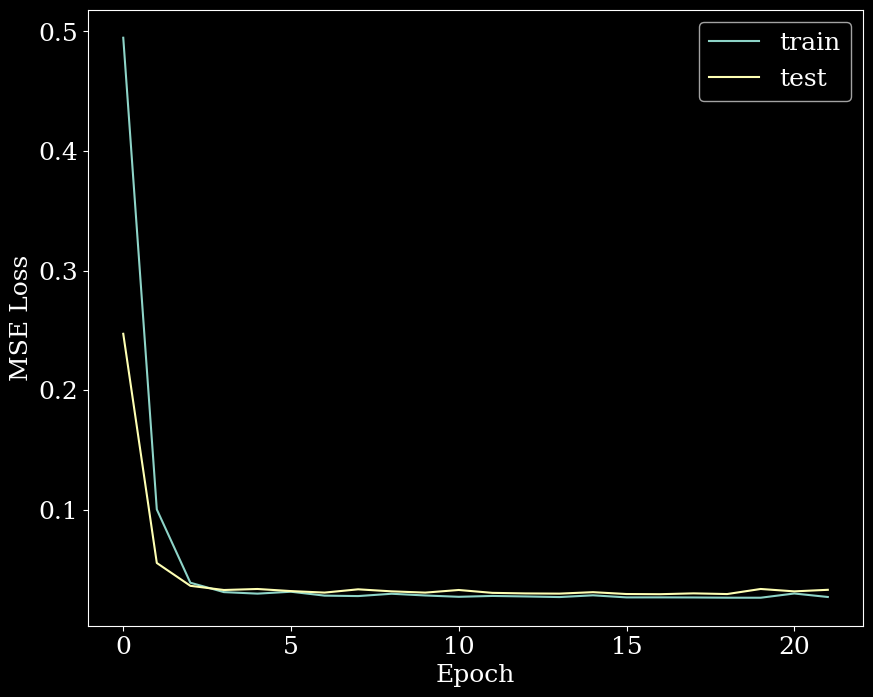

In [8]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


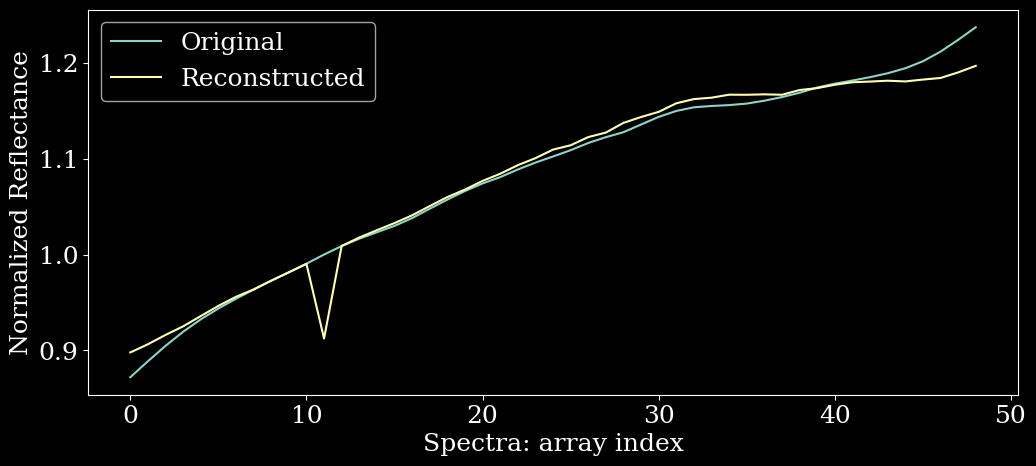

In [9]:
# Which index shall be displayed?
index_val = 100

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()

In [10]:
# Create dataframe that contains the encoder values (2 values at bottleneck) and the corresponding
# class to see whether the autoencoder values cluster in a way

# Encode the spectra
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=["enc1", "enc2", "Main_Group", "Bus_Class"])

# Change the dtype to float
encoded_df.loc[:, "enc1"] = encoded_df["enc1"].astype(float)
encoded_df.loc[:, "enc2"] = encoded_df["enc2"].astype(float)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


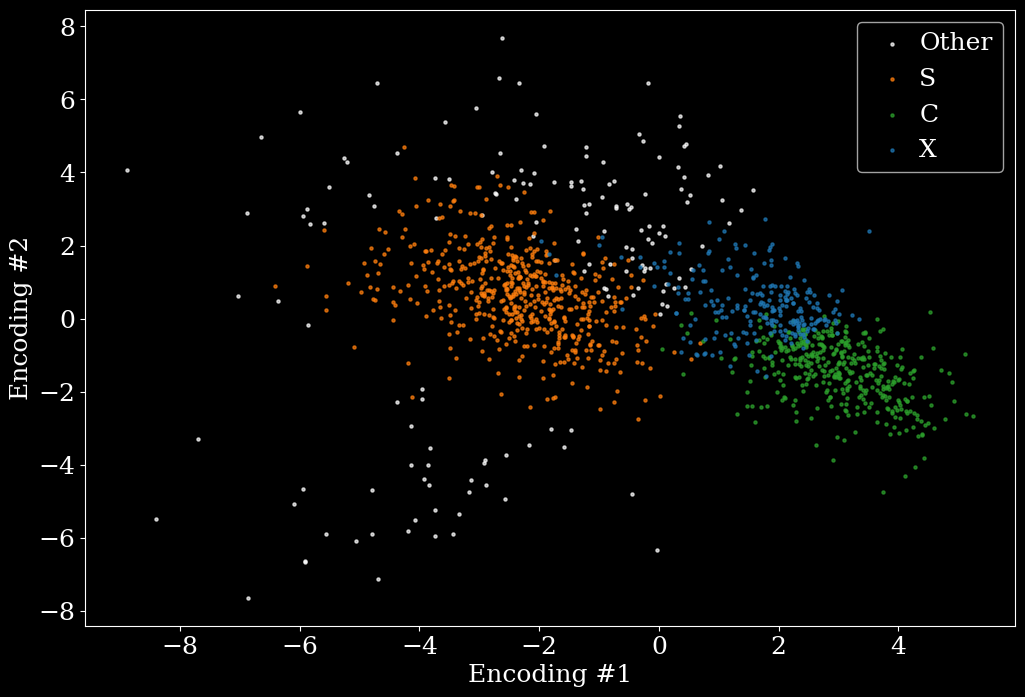

In [11]:
# Plot now the autoencoder values for the Main Group

# Create a dictionary to color the classes
color_dict = {'Other': 'w',
              'S': 'tab:orange',
              'C': 'tab:green',
              'X': 'tab:blue'}

# Set a plot
plt.figure(figsize=(12,8))

# Create a scatter plot with the encoder values and assign the colors to the corresponding classes
for asteroid_class, cluster_color in color_dict.items():
    plt.scatter(encoded_df.loc[encoded_df["Main_Group"] == asteroid_class]["enc1"],
                encoded_df.loc[encoded_df["Main_Group"] == asteroid_class]["enc2"],
                marker='o',
                s=5,
                alpha=0.7,
                color=cluster_color,
                label=asteroid_class)

# Set xlabels
plt.xlabel("Encoding #1")
plt.ylabel("Encoding #2")

plt.legend()

ax = plt.gca()
ax.legend(handletextpad=0.1)

plt.show()

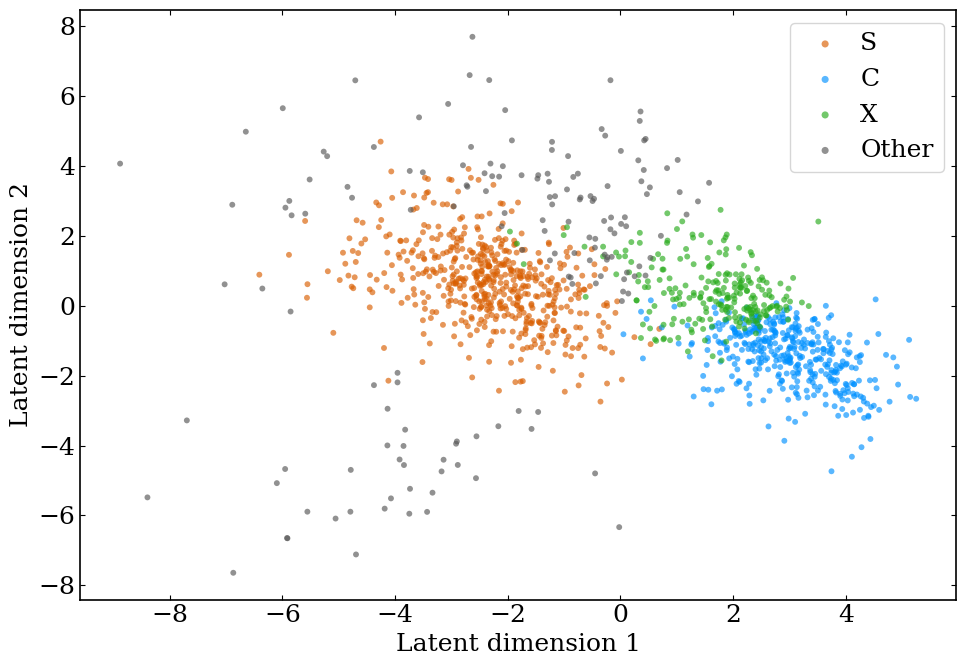

In [ ]:
import matplotlib.pyplot as plt

# -----------------------------
# Styling: white background, serif font
# -----------------------------
plt.style.use("default")
plt.rc("font", family="serif", size=18)

# Color-blind friendly palette
color_dict = {
    "S": "#d95e00",     # orange
    "C": "#0091ff",     # blue
    "X": "#28ab1c",     # green
    "Other": "#575757" # grey
}

fig, ax = plt.subplots(figsize=(10, 7))

# -----------------------------
# Scatter plot in latent space
# -----------------------------
for asteroid_class, cluster_color in color_dict.items():
    plt.scatter(encoded_df.loc[encoded_df["Main_Group"] == asteroid_class]["enc1"],
                encoded_df.loc[encoded_df["Main_Group"] == asteroid_class]["enc2"],
                marker='o',
                s=18,
                alpha=0.65,
                color=cluster_color,
                edgecolors="none",
                label=asteroid_class
                )

# -----------------------------
# Axes labels
# -----------------------------
ax.set_xlabel("Latent dimension 1")
ax.set_ylabel("Latent dimension 2")

# -----------------------------
# Ticks & spines (journal style)
# -----------------------------
ax.tick_params(direction="in", top=True, right=True)
for spine in ax.spines.values():
    spine.set_linewidth(1.2)

# -----------------------------
# Legend (clean, unobtrusive)
# -----------------------------
ax.legend(
    frameon=True,
    markerscale=1.2,
    handletextpad=0.4
)

# -----------------------------
# Layout & save
# -----------------------------
# plt.tight_layout()
# plt.savefig(
#     "latent_space_main_group.png",
#     dpi=300,
#     bbox_inches="tight"
# )

plt.show()


In [ ]:
# Let's create now an interactive plot for the Bus Class! Do we see clusters in the Bus-Class
# domain?
%matplotlib inline
import ipywidgets

# In our plot we will plot only the "top 20" Bus Classes (sorted by number)
top_bus = encoded_df.groupby('Bus_Class')['Main_Group'].count().nlargest(20)
bus_classes = sorted(top_bus.index)

# Filter the dataframe
encoded_train_df = encoded_df[encoded_df["Bus_Class"].isin(top_bus.index)].copy()

# Get a list of all Bus Classes
bus_classes = sorted(encoded_df["Bus_Class"].unique())

# Create a Selection widget
# Note: Press Shift or Cntrl (Windows) / CMD (MacOS) to choose multiple classes
selector = ipywidgets.SelectMultiple(options = bus_classes,
                                     value = [bus_classes[0]],
                                     rows = 10,
                                     description = 'Variables',
                                     disabled = False)

# Get the selected items
output = ipywidgets.Output()
display(selector)
display(output)

# Create a colormap, the colors and create a color dictionary
cmap = plt.get_cmap('tab20')
colors = cmap(np.linspace(0, 1, len(bus_classes)))
for k, c in zip(bus_classes, colors):
    color_dict[k] = c

# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Set a function for the (interactive) plots
def plot_encoding(widg):

    # Get the selected choices
    choices = widg['new']

    # Filter the dataframe based on the selection
    data = encoded_df.loc[encoded_df["Bus_Class"].isin(choices)] if choices \
               else encoded_df
    output.clear_output(wait=True)

    with output:

        # Create a "wide screen figure"
        fig, ax = plt.subplots(figsize=(20,8))

        # Plot the encoding values within a for loop to create easily a legend for each group
        for bus_k in np.unique(data["Bus_Class"]):

            ax.scatter(data.loc[data["Bus_Class"] == bus_k]["enc1"],
                       data.loc[data["Bus_Class"] == bus_k]["enc2"],
                       marker = 'o',
                       s = 15,
                       alpha = 0.7,
                       color = color_dict.get(bus_k),
                       label = bus_k)

        # Create the legend
        ax.legend()

        # Set labels
        plt.xlabel("Encoding #1")
        plt.ylabel("Encoding #2")

        # Set limits
        plt.xlim(np.min(encoded_df["enc1"]), np.max(encoded_df["enc1"]))
        plt.ylim(np.min(encoded_df["enc2"]), np.max(encoded_df["enc2"]))

        plt.show()

# Create an interactive session!
selector.observe(plot_encoding, names='value')

SelectMultiple(description='Variables', index=(0,), options=('A', 'B', 'C', 'Cb', 'Cg', 'Cgh', 'Ch', 'D', 'K',…

Output()